In [20]:
# Package installation
# install.packages('dplyr')
# install.packages('jsonlite')
# install.packages('lubridate')
# install.packages('ggplot2')
# install.packages('quantmod')
# install.packages('lifecycle')
# install.packages('tidyselect')
# install.packages("tidyverse")
# install.packages("zoo")


In [21]:
# Load necessary libraries
library(dplyr)
library(jsonlite)
library(lubridate)
library(ggplot2)
library(quantmod)
library(lifecycle)
library(tidyselect)
library(tidyverse)
library(zoo)


In [22]:
# Read the CSV file into a dataframe
WIN_PRO_df <- read.csv("csv_files/win_data_pro.csv")
PLACE_PRO_df <- read.csv("csv_files/place_data_PRO.csv")

In [23]:
# Filter only on the rows where actual trades have been made
WIN_PRO_df <- WIN_PRO_df %>% filter(trades != "[]")
PLACE_PRO_df <- PLACE_PRO_df %>% filter(trades != "[]")

# Remove trades column
WIN_PRO_df <- WIN_PRO_df %>% select(-trades)
PLACE_PRO_df <- PLACE_PRO_df %>% select(-trades)

# Convert timestamp to POSIXct
WIN_PRO_df <- WIN_PRO_df %>%
  mutate(timestamp = as.POSIXct(timestamp_unix / 1000, origin = "1970-01-01", tz = "GMT"))

PLACE_PRO_df <- PLACE_PRO_df %>%
  mutate(timestamp = as.POSIXct(timestamp_unix / 1000, origin = "1970-01-01", tz = "GMT"))

# Create a equal frequency bin for time
WIN_PRO_df <- WIN_PRO_df %>%
  mutate(six_sec_bucket = floor(as.numeric(timestamp) / 6))

PLACE_PRO_df <- PLACE_PRO_df %>%
  mutate(six_sec_bucket = floor(as.numeric(timestamp) / 6))

# Create a size and price column. Price is set to last traded price, which is fine because we filtered out the rows with no trades.
#Hence price is now actual trades, and size will be worked out later for each horse.
WIN_PRO_df <- WIN_PRO_df %>%
  mutate(
    #size = NA,
    price = last_traded_price
  )

PLACE_PRO_df <- PLACE_PRO_df %>%
  mutate(
    #size = NA,
    price = last_traded_price
  )


In [24]:
# Read the horse name data into a dataframe
horse_names_df <- data.frame(
  horse_id = c(8421889, 5105924, 5465145, 3415981, 7560122, 7401388),
  horse_name = c("Romsdal", "Brown Panther", "Havana Beat", "Times Up", "Snow Sky", "Island Remede")
)

In [25]:
# Join the horse name data with the main dataframe
WIN_PRO_df <- WIN_PRO_df %>%
  left_join(horse_names_df, by = c("horse_id" = "horse_id"))

PLACE_PRO_df <- PLACE_PRO_df %>%
  left_join(horse_names_df, by = c("horse_id" = "horse_id"))

In [26]:
# Important instances to split df
PP_t <- "2015-05-15 16:10:00"
IP_t <- "2015-05-15 16:16:10"

# Split the data frame into three parts based on the given times
WIN_PRO_df_Morning <- WIN_PRO_df %>% filter(timestamp < PP_t)
WIN_PRO_df_PP <- WIN_PRO_df %>% filter(timestamp >= PP_t & timestamp < IP_t)
WIN_PRO_df_IP <- WIN_PRO_df %>% filter(timestamp >= IP_t)

PLACE_PRO_df_Morning <- PLACE_PRO_df %>% filter(timestamp < PP_t)
PLACE_PRO_df_PP <- PLACE_PRO_df %>% filter(timestamp >= PP_t & timestamp < IP_t)
PLACE_PRO_df_IP <- PLACE_PRO_df %>% filter(timestamp >= IP_t)

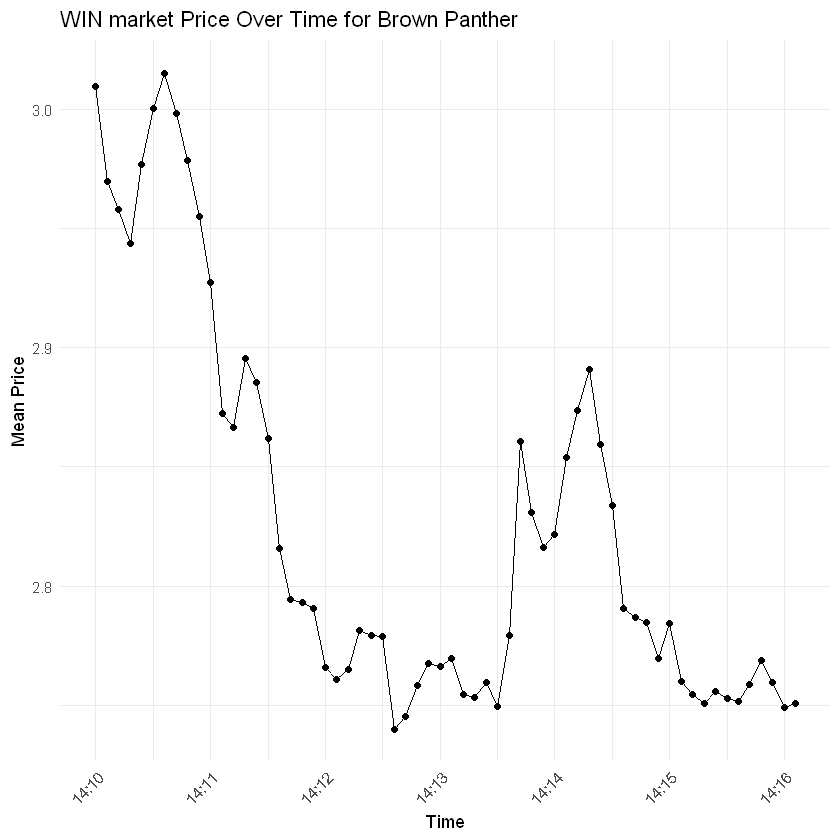

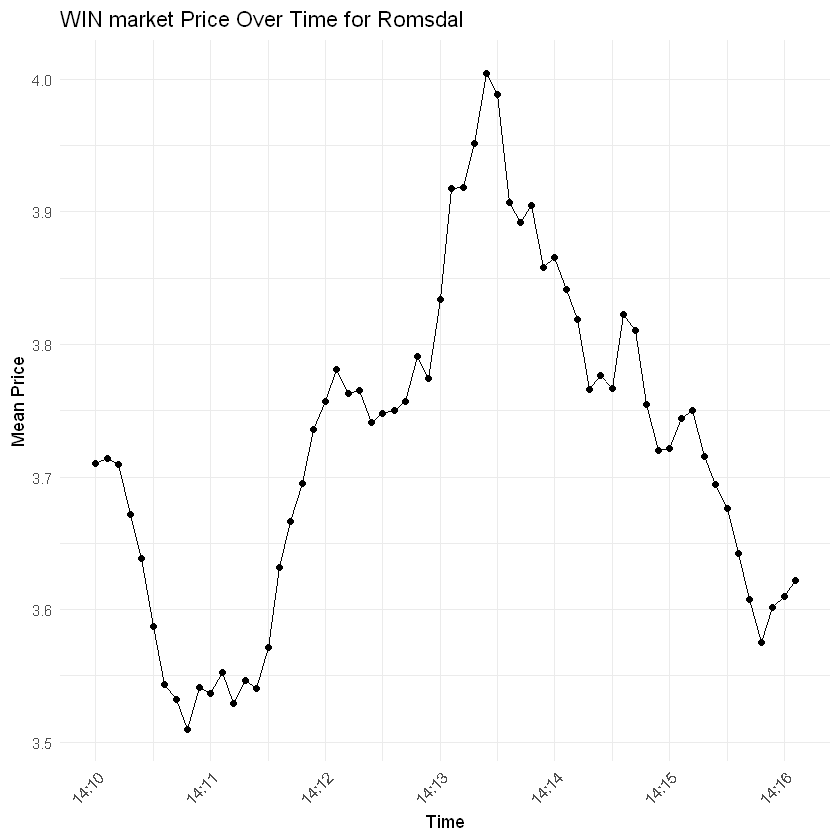

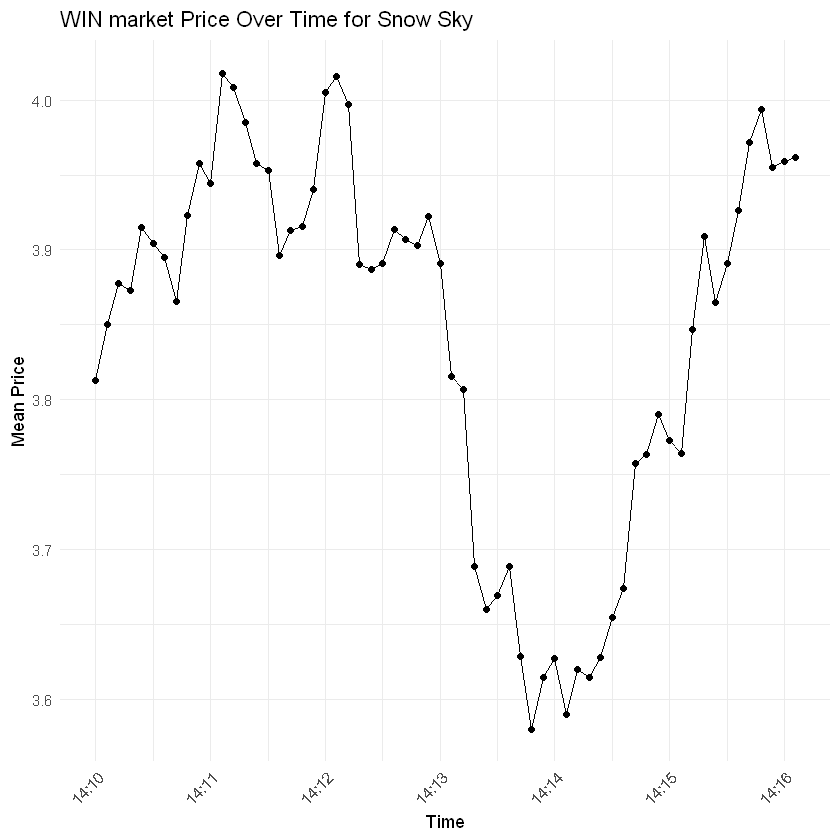

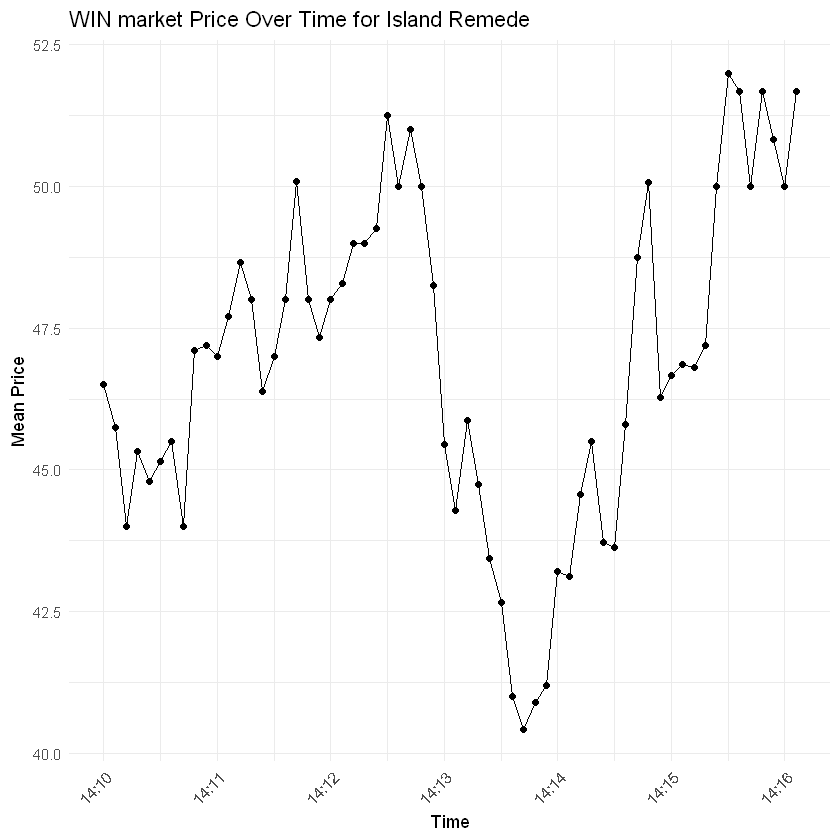

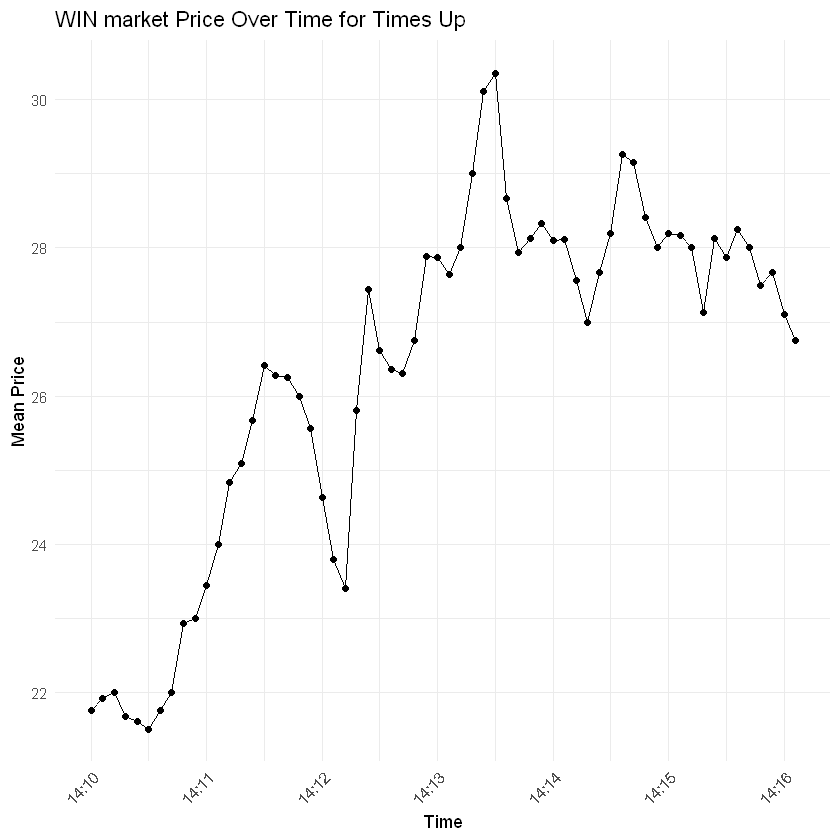

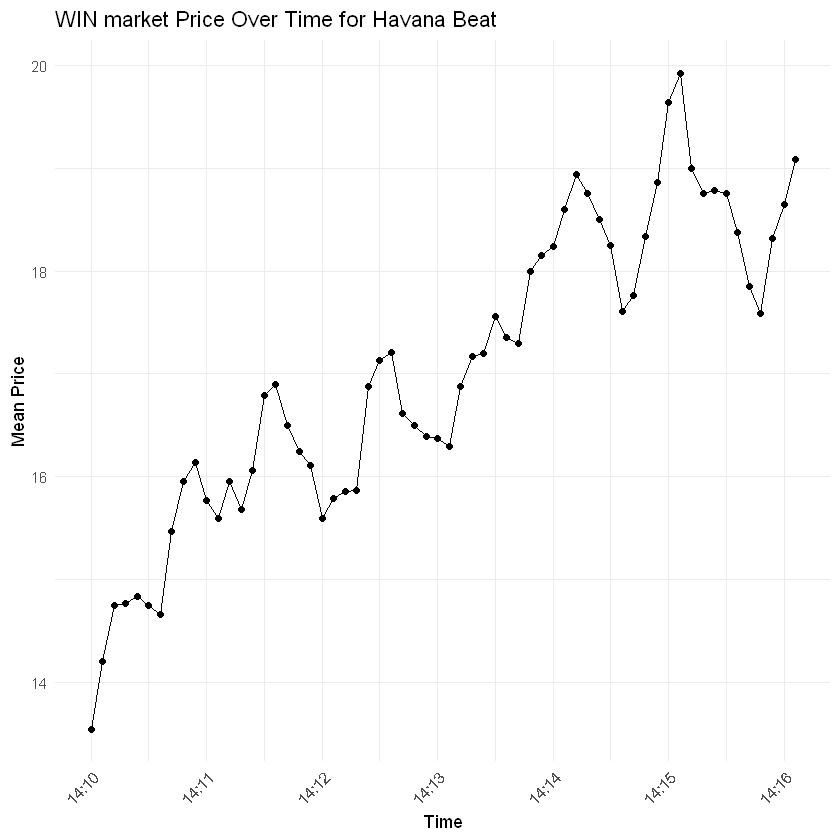

In [27]:
# Loop through each horse and create a plot and save dataframe for WIN_PRO_df
for (horse in unique(WIN_PRO_df$horse_name)) {
  horse_df <- WIN_PRO_df_PP %>% filter(horse_name == horse)
  
  # Calculate the size column for each horse within the loop
  #horse_df <- horse_df %>%
    #arrange(timestamp) %>%
    #mutate(size = traded_volume - lag(traded_volume, default = first(traded_volume)),
           #size = ifelse(size < 0, 0, size))
  
  # Group by six_sec_bucket and calculate the size and Mean Price
  horse_df <- horse_df %>%
    group_by(six_sec_bucket) %>%
    summarise(
      #total_size = sum(size, na.rm = TRUE),
      mean_price = mean(price, na.rm = TRUE)
    )
  
  # Save the horse-specific dataframe to a variable named after the horse
  assign(paste0(gsub(" ", "_", horse), "_WIN_df"), horse_df)
  
  # Create the plot with only price
  p <- ggplot(data = horse_df, aes(x = as.POSIXct(six_sec_bucket * 6, origin = "1970-01-01", tz = "GMT"), y = mean_price)) +
    geom_line() +
    geom_point() +
    labs(
      title = paste("WIN market Price Over Time for", horse),
      x = "Time",
      y = "Mean Price"
    ) +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      legend.position = "bottom"
    ) +
    scale_x_datetime(date_breaks = "1 min", date_labels = "%H:%M")
  
  # Print the plot
  print(p)
}
  

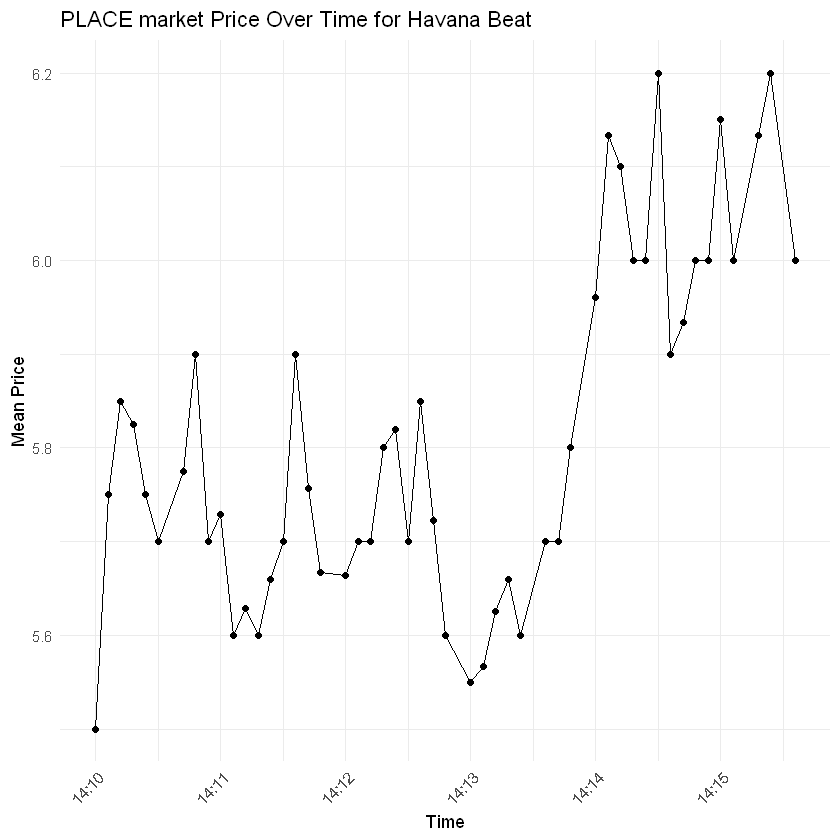

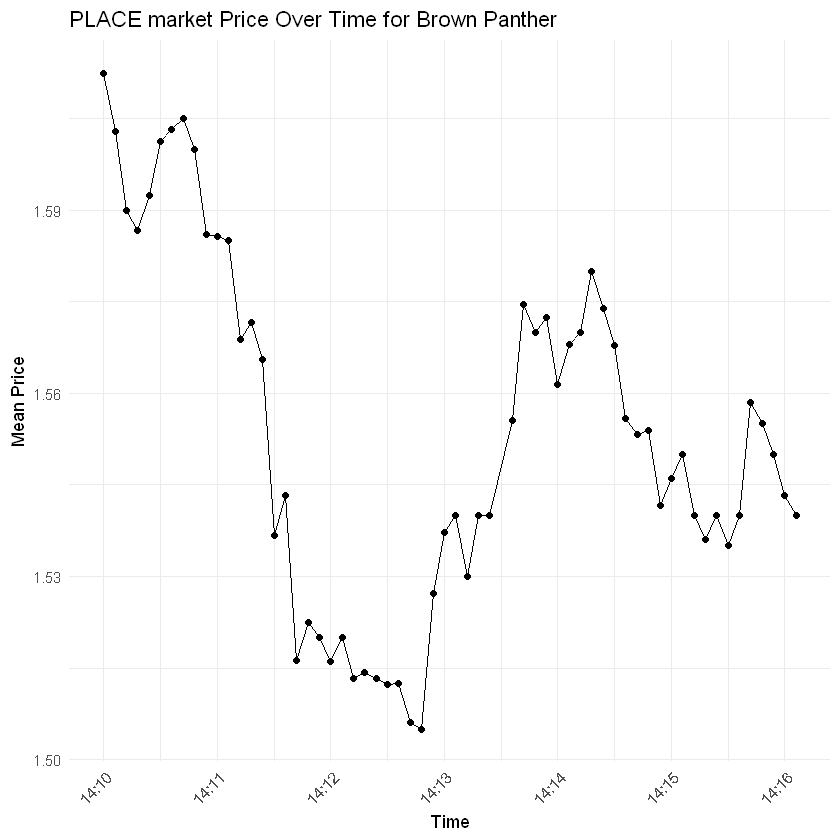

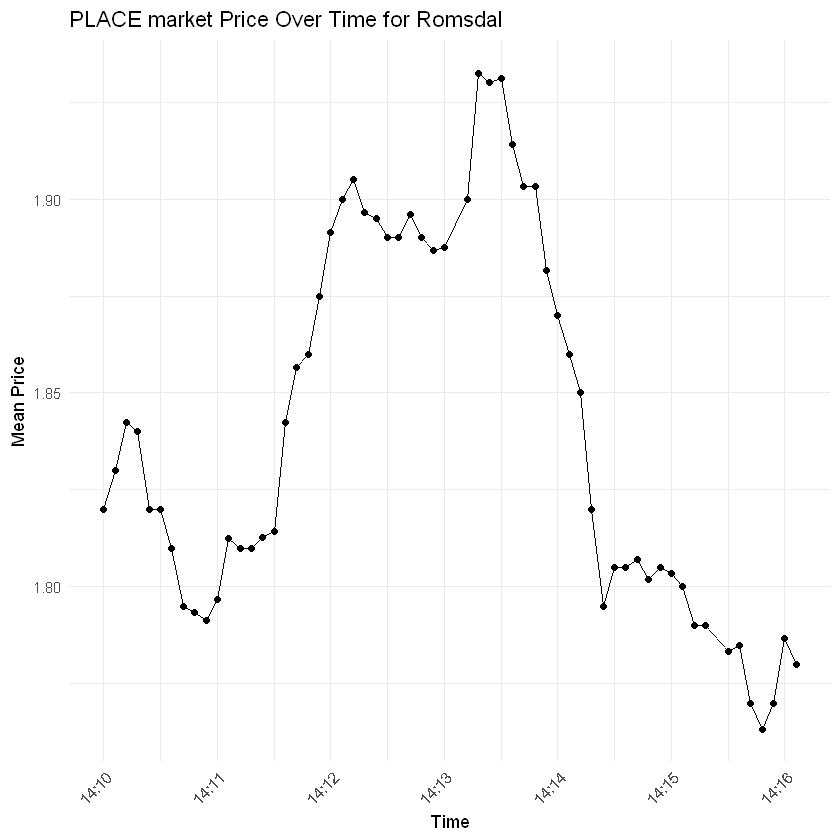

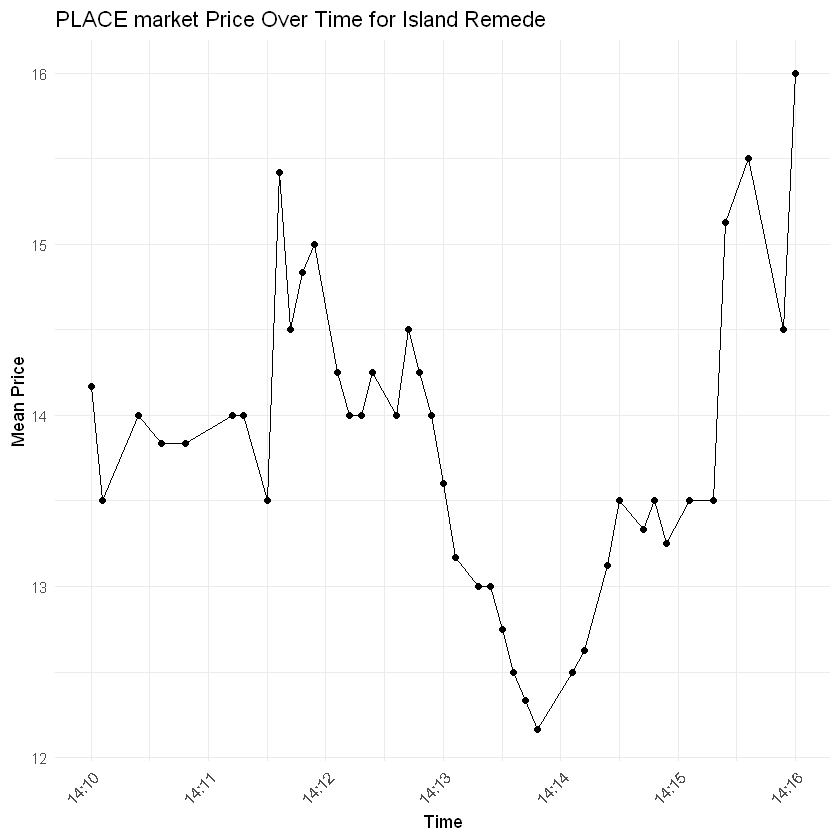

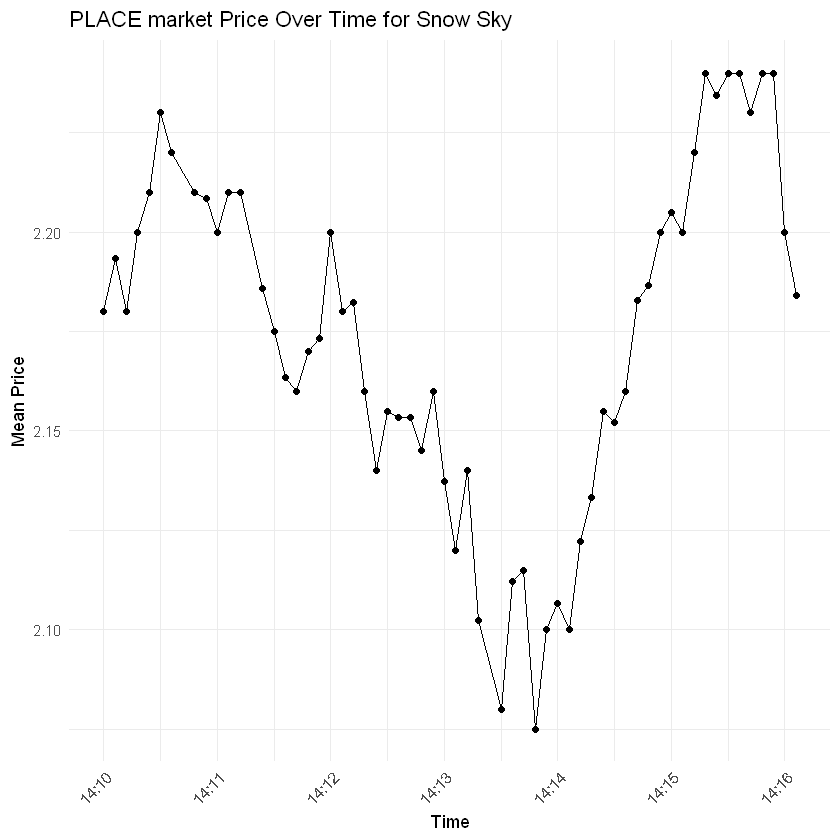

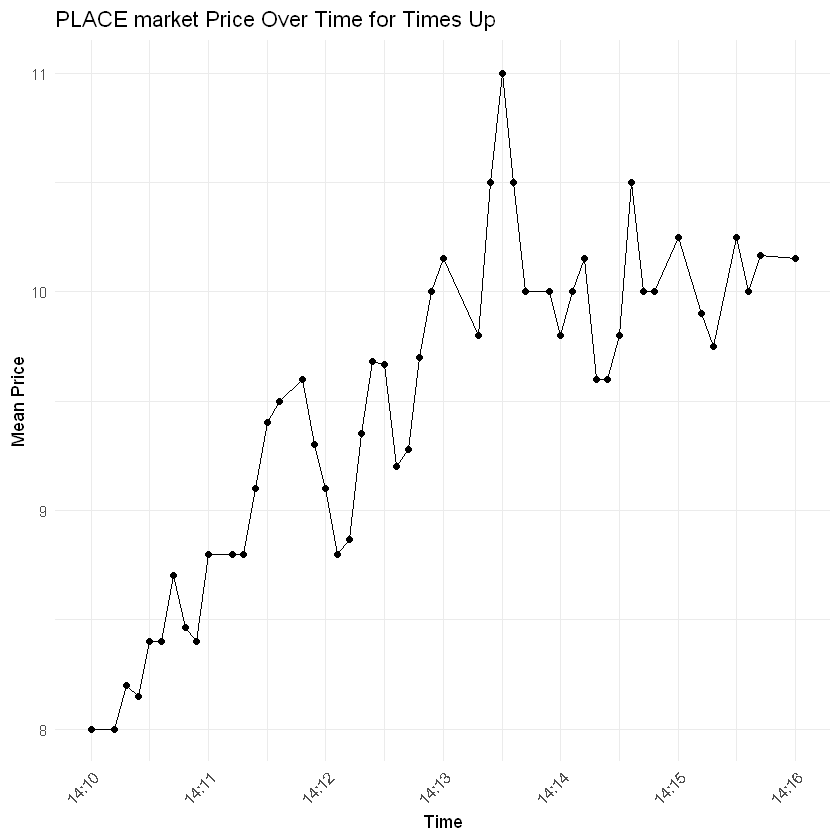

In [28]:
# Loop through each horse and create a plot and save dataframe for PLACE_PRO_df
for (horse in unique(PLACE_PRO_df$horse_name)) {
  horse_df <- PLACE_PRO_df_PP %>% filter(horse_name == horse)
  
  # Calculate the size column for each horse within the loop
  #horse_df <- horse_df %>%
    #arrange(timestamp) %>%
    #mutate(size = traded_volume - lag(traded_volume, default = first(traded_volume)),
           #size = ifelse(size < 0, 0, size))
  
  # Group by six_sec_bucket and calculate the size and Mean Price
  horse_df <- horse_df %>%
    group_by(six_sec_bucket) %>%
    summarise(
      #total_size = sum(size, na.rm = TRUE),
      #mean_price = sum(price * size, na.rm = TRUE) / sum(size, na.rm = TRUE)
      mean_price = mean(price, na.rm = TRUE)
    )
  
  # Save the horse-specific dataframe to a variable named after the horse
  assign(paste0(gsub(" ", "_", horse), "_PLACE_df"), horse_df)
  
  # Create the plot with only price
  p <- ggplot(data = horse_df, aes(x = as.POSIXct(six_sec_bucket * 6, origin = "1970-01-01", tz = "GMT"), y = mean_price)) +
    geom_line() +
    geom_point() +
    labs(
      title = paste("PLACE market Price Over Time for", horse),
      x = "Time",
      y = "Mean Price"
    ) +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      legend.position = "bottom"
    ) +
    scale_x_datetime(date_breaks = "1 min", date_labels = "%H:%M")
  
  # Print the plot
  print(p)
}

### EXPLORATORY DATA ANALYSIS WIN MARKET (SELECTING SNOW SKY)


In [29]:
head(Snow_Sky_WIN_df)

six_sec_bucket,mean_price
<dbl>,<dbl>
238616500,3.812500
238616501,3.850000
238616502,3.877500
238616503,3.873077
238616504,3.914706
238616505,3.904545


In [33]:
# Load necessary libraries
library(tidyverse)
library(lubridate)
library(ggplot2)
library(forecast)
library(tseries)


####THIS FILTERING IS NOT REQUIRED, Snow_Sky_WIN_df is already prepared

# Assuming 'horse_trading_data' is your dataset containing all the trading information.

# Step 1: Data Preparation
# Filter the dataset for the horse named "Snow Sky Bird"
#snow_sky_df <- Snow_Sky_WIN_df %>%
  #filter(horse_name == "Snow Sky")

# Convert timestamps to proper datetime format if necessary
#snow_sky_df$timestamp <- as.POSIXct(snow_sky_df$timestamp, format="%Y-%m-%d %H:%M:%S")

# Ensure data is sorted by timestamp
#snow_sky_df <- arrange(snow_sky_df, timestamp)






In [32]:
# Step 2: Data Exploration
# Summary statistics of key variables
summary(Snow_Sky_WIN_df$mean_price)
#summary(snow_sky_df$traded_volume)### I removed Vol, as it is a bit dodgy

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.580   3.763   3.891   3.844   3.937   4.018 

In [37]:
# Check for missing values
sum(is.na(Snow_Sky_WIN_df$mean_price))
#sum(is.na(snow_sky_df$traded_volume))### I removed Vol, as it is a bit dodgy

# Check duplicate rows
sum(duplicated(Snow_Sky_WIN_df))


[1] 0

[1] 0

In [38]:
head(Snow_Sky_WIN_df)

six_sec_bucket,mean_price
<dbl>,<dbl>
238616500,3.812500
238616501,3.850000
238616502,3.877500
238616503,3.873077
238616504,3.914706
238616505,3.904545


In [ ]:
# # Extract timestamp column and price column
#Snow_Sky_WIN_df <- data.frame(timestamp = Snow_Sky_WIN_df$timestamp, price = Snow_Sky_WIN_df$price)

# Aggregate data by unique timestamps
#snow_sky_df <- snow_sky_df %>%
  #group_by(timestamp) %>%
  #summarize(price = mean(price, na.rm = TRUE))




In [41]:
head(Snow_Sky_WIN_df)

six_sec_bucket,mean_price
<dbl>,<dbl>
238616500,3.812500
238616501,3.850000
238616502,3.877500
238616503,3.873077
238616504,3.914706
238616505,3.904545


In [39]:
str(Snow_Sky_WIN_df)

tibble [62 × 2] (S3: tbl_df/tbl/data.frame)
 $ six_sec_bucket: num [1:62] 2.39e+08 2.39e+08 2.39e+08 2.39e+08 2.39e+08 ...
 $ mean_price    : num [1:62] 3.81 3.85 3.88 3.87 3.91 ...


In [40]:
#USE NEXT CELL

# Extract the price data
#price_data <- Snow_Sky_WIN_df$mean_price

# Create a time series object with a frequency of 1 observation per second
#win_price_ts <- ts(price_data, frequency = 1, start = c(2015, as.numeric(format(min(Snow_Sky_WIN_df$six_sec_bucket), "%j"))))

# Check the structure of the time series object
#str(win_price_ts)



#head(win_price_ts)

ERROR: Error in prettyNum(.Internal(format(x, trim, digits, nsmall, width, 3L, : invalid 'trim' argument


In [61]:
# Convert 'six_sec_bucket' to POSIXct for proper time handling
Snow_Sky_WIN_df <- Snow_Sky_WIN_df %>%
  mutate(timestamp = as.POSIXct(six_sec_bucket * 6, origin = "1970-01-01", tz = "GMT"))

# Check the range of the timestamp
start_time <- min(Snow_Sky_WIN_df$timestamp)
end_time <- max(Snow_Sky_WIN_df$timestamp)

# Create a sequence of time points from start to end with a step of 6 seconds
time_points <- seq(from = start_time, to = end_time, by = "6 sec")

# Create a complete data frame with these time points
complete_data <- data.frame(timestamp = time_points)

# Merge with the original data to ensure alignment
complete_data <- complete_data %>%
  left_join(Snow_Sky_WIN_df, by = "timestamp")

# Fill missing prices with NA or any other method if necessary
complete_data <- complete_data %>%
  mutate(mean_price = ifelse(is.na(mean_price), NA, mean_price))

# Check the filled price data
summary(complete_data$mean_price)

# Extract the filled price data
filled_price_data <- complete_data$mean_price

# Create the time series object
# Use a lower frequency to match the length of the time series
# For example, assuming a reasonable periodicity within the data length
win_price_ts <- ts(filled_price_data, frequency = 10)

# Check the structure and length of the time series object
str(win_price_ts)
length(win_price_ts)

# Display the first few entries of the time series object
head(win_price_ts)



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.580   3.763   3.891   3.844   3.937   4.018 

 Time-Series [1:62] from 1 to 7.1: 3.81 3.85 3.88 3.87 3.91 ...


[1] 62

A Time Series:
[1] 3.812500 3.850000 3.877500 3.873077 3.914706 3.904545

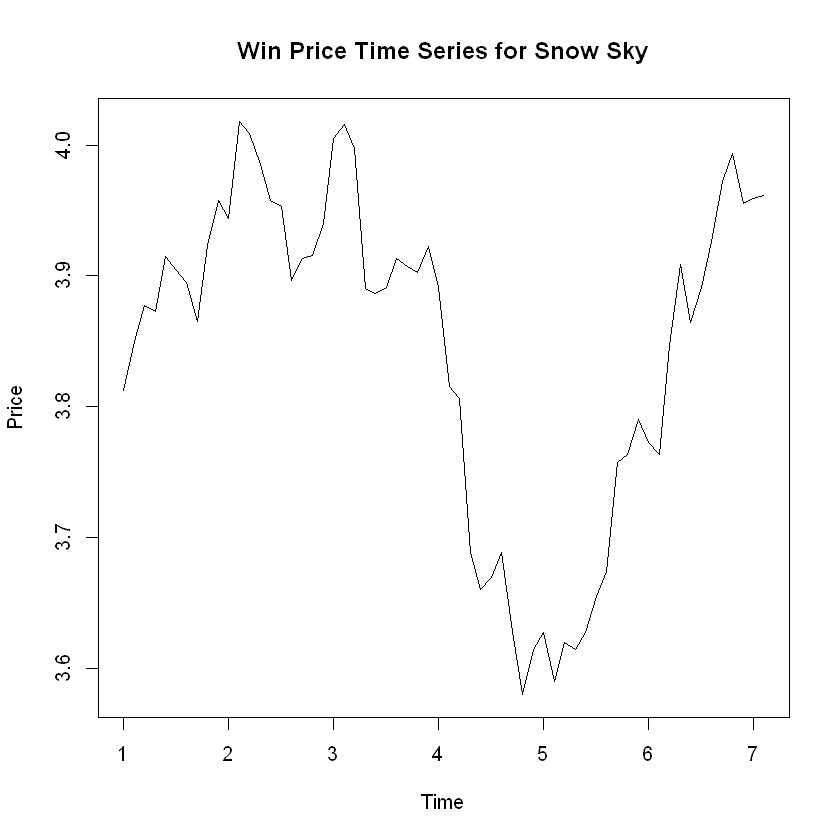

In [62]:
plot(win_price_ts, main="Win Price Time Series for Snow Sky", xlab="Time", ylab="Price", type="l")

In [63]:
# Step 4: Statistical Tests
# Testing for stationarity
adf_test_result <- adf.test(win_price_ts, alternative = "stationary")
print(adf_test_result)




	Augmented Dickey-Fuller Test

data:  win_price_ts
Dickey-Fuller = -1.1145, Lag order = 3, p-value = 0.9128
alternative hypothesis: stationary



Its not stationary. Therefore we need to break it down and to understand the underlying components.


In [47]:
#NOT SURE IF THIS IS REQUIRED?
# Enhanced boxplot visualization of monthly price distribution per year
snow_sky_df %>%
  mutate(year = year(timestamp), month = month(timestamp), month_name = month(timestamp, label = TRUE)) %>%
  ggplot(aes(x = month_name, y = price, fill = month_name)) +  # Use month name and fill by month
  geom_boxplot(outlier.shape = NA) +  # Remove default outlier points
  geom_jitter(width = 0.1, alpha = 0.5, color = "darkgray") +  # Add jittered points for individual data observation
  scale_fill_brewer(palette = "Paired") +  # Apply a color palette for aesthetics
  labs(title = "Price Distribution ",
       subtitle = "Snow Sky",) +
  facet_wrap(~year) +  # Facet by year to see year-wise trends
  theme_minimal() +  # Use a minimal theme
  theme(
    strip.background = element_rect(fill = "lightblue", color = "deepskyblue", size = 1),  # Customize facet headers
    strip.text = element_text(face = "bold"),  # Bold facet header text
    axis.text.x = element_text(angle = 45, hjust = 1),  # Improve x-axis label readability
    legend.position = "none",  # Hide the legend as the color is self-explanatory
    plot.title = element_text(hjust = 0.5),  # Center the title
    plot.subtitle = element_text(hjust = 0.5)  # Center the subtitle
  )


ERROR: Error in eval(expr, envir, enclos): object 'snow_sky_df' not found


In [58]:
# Step 5: Decomposition of Time Series (if seasonal patterns expected)

# Install necessary packages if not already installed
# install.packages("tsibble")
# install.packages("feasts")
# install.packages("fabletools")

# Load necessary libraries
library(tidyverse)
library(lubridate)
library(tsibble)
library(feasts)
library(fabletools)






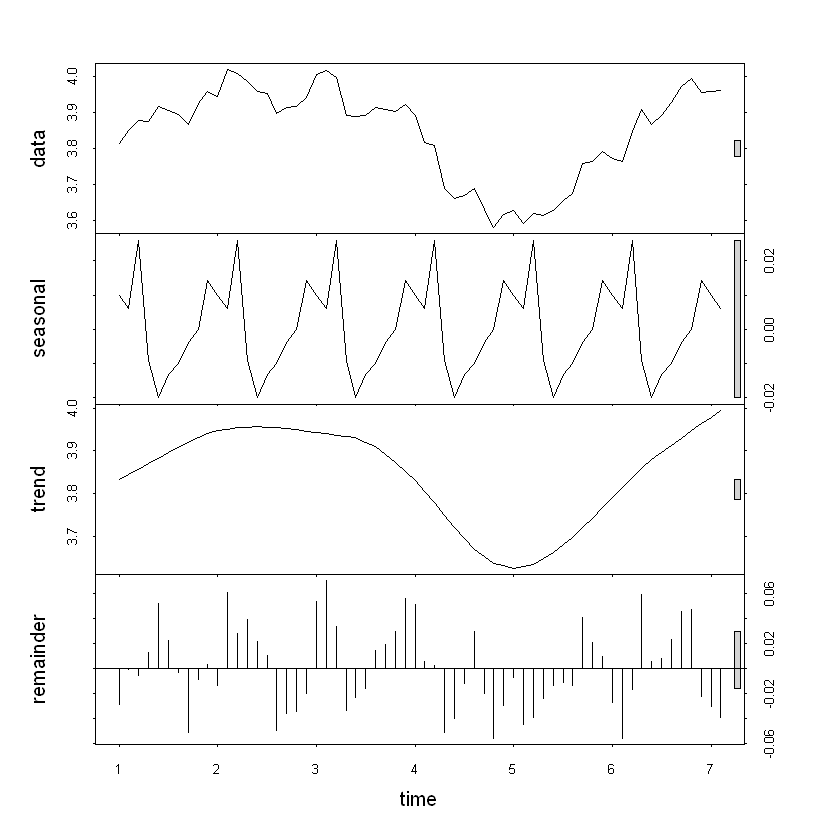

In [64]:
# Step 5: Decomposition of Time Series (if seasonal patterns expected)
decomposed <- stl(win_price_ts, s.window = "periodic")
plot(decomposed)



In [ ]:
##HAD TO REMOVE VOLUME AS IT IS DODGY

# Correlation analysis
#correlation <- cor(snow_sky_df$traded_volume, snow_sky_df$price, use = "complete.obs")
#print(paste("Correlation between price and traded volume: ", correlation))



ERROR: Error in cor(snow_sky_df$traded_volume, snow_sky_df$price, use = "complete.obs"): 'x' must be numeric


In [ ]:
#plot()

In [72]:
snow_sky_diff_1 <- diff(Snow_Sky_WIN_df$mean_price, lag = 1)



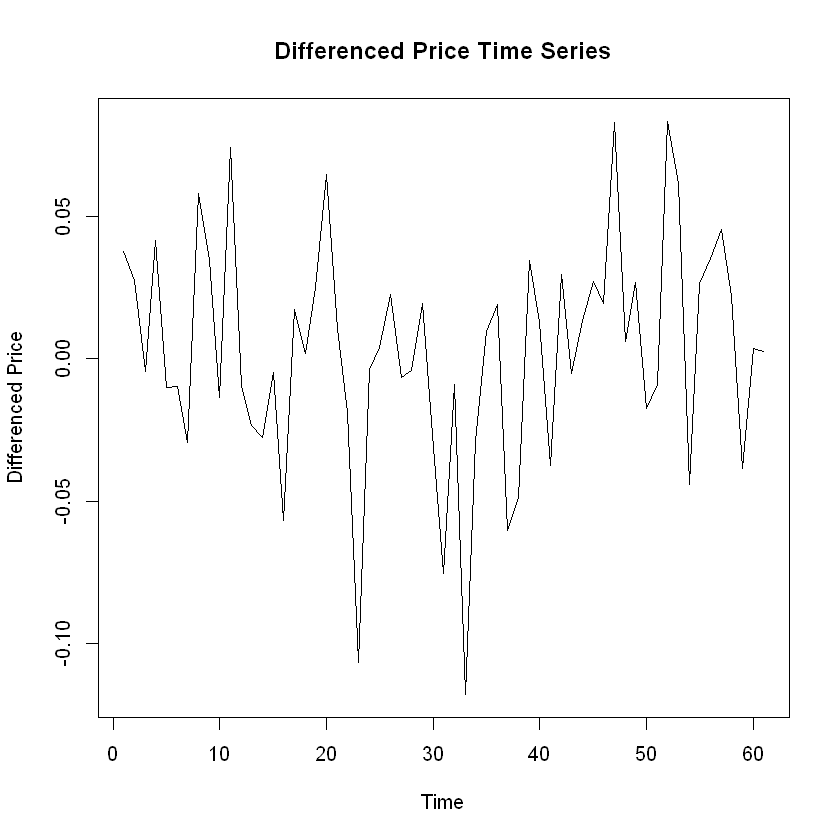

In [73]:
plot(snow_sky_diff_1, main="Differenced Price Time Series", xlab="Time", ylab="Differenced Price", type="l")

In [74]:
adf_result_diff <- adf.test(snow_sky_diff_1, alternative = "stationary")
print(adf_result_diff)


	Augmented Dickey-Fuller Test

data:  snow_sky_diff_1
Dickey-Fuller = -3.4663, Lag order = 3, p-value = 0.05375
alternative hypothesis: stationary



## Test Stationarity of the Remainder
After decomposition, the remainder component should ideally be stationary. However, testing for stationarity is crucial to confirm.

In [ ]:
# Extract components
seasonal <- decomposed$time.series[, "seasonal"]
trend <- decomposed$time.series[, "trend"]
remainder <- decomposed$time.series[, "remainder"]

In [ ]:
library(tseries)
# ADF test on the remainder
adf_test_remainder <- adf.test(remainder, alternative = "stationary")
print(adf_test_remainder)


## Handling Non-stationarity